In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
BATCH_SIZE = 16
N_GRAM = 64
# MODEL_DIR = './music_model/04_21_19_LayersGeneric_transfer_256_128_classical_cleaned_small_batchsize20_window30/'
# MODEL_DIR = './music_model/04_24_19_LSTMSkipConnection_classical_small_drop45_128_256_128_batchsize20_window30/'
# MODEL_DIR = './music_model/LSTMSkipConnection_many2many_128_256_128_layers_lstm/'
MODEL_DIR = './music_model/04_25_19_LSTMSkipConnection_jig_horn_drop25_dropbeteween_regularization_128_256_128_batchsize20_window30_adam_decay1e-6_reg0.005_01lrate/'
# MODEL_DIR = './music_model/04_20_19_LayersRNNGeneric_256_128_classical_fixed_activation_batchsize8000/'
# MODEL_DIR = './music_model/04_20_19_LayersRNNGeneric_256_128_jig_hog_fixed_activation_batchsize16/'#good model
DATA_PATH = './data/jig_hornpipes_cleaned.txt'
DATA_PATH = './data/classical_music_midi/processed_clean_abc_small.txt'
MODEL_TYPE = 'Default'#unuse for now
BATCH_SIZE = 1
starting = '''B4 d4 [G4B,4] | [B4D4] [D4B,4G,4] [G4B,4D4] | [D,4B,,4G,4] [G,4D,4B,4]'''
SEQ_LENGTH = 30

In [3]:
SEQ_LENGTH

30

In [4]:
with open(os.path.join(MODEL_DIR, 'model_dictionary.json')) as f:
    vocab_map = json.load(f)

n_vocab = len(vocab_map['idx2char'])

print('n_vocab', n_vocab)

n_vocab 34


In [5]:
from src.models import MusicModel
# model = MusicModel(n_vocab).TwoLayerLSTM(batch_input_shape=(BATCH_SIZE, 1))
# model = MusicModel(n_vocab).TwoLayerLSTM(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH))

# model = MusicModel(n_vocab, 'test').LayersRNNGeneric(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                                             layers=['lstm', 'lstm'], 
#                                              layers_size=[256, 128],
#                                              emb_dim=512,
#                                              drop_rate=0.15)
# model = MusicModel(n_vocab, phase='test').BidirectionalLayersRNNGeneric(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                                                     layers=['lstm','lstm'], 
#                                                      emb_dim=256,
#                                                      layers_size=[256, 128], drop_rate=0.6)

model = MusicModel(n_vocab).LSTMSkipConnection(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                                                                 layers=[128, 256, 128],
                                                               layers = [128,256,128],
                                                                emb_dim=256,drop_emb=0.15,
                                                               drop_rate=0.10)

# model = MusicModel(n_vocab, phase='test').ResidualLSTM(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                                         rnn_width=128,
#                                         rnn_depth=5,
#                                         drop_rate=0.15)

# model = MusicModel(n_vocab).LSTMSkipConnectionDropBetween(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#             layers=[256, 256], 
#             emb_dim=356, drop_rate=0.15)
    
# model = MusicModel(n_vocab).LSTMSkipConnection(batch_input_shape=(BATCH_SIZE, SEQ_LENGTH),
#                     layers=[128, 256, 128],
# #                     layers = [256],
#                     emb_dim=256,drop_rate=0.45)
print('\n',model.summary())


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (1, 30)              0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (1, 30, 256)         8704        input[0][0]                      
__________________________________________________________________________________________________
drop_layer1 (Dropout)           (1, 30, 256)         0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm_layer0 (LSTM)              (1, 30, 128)         197120      drop_layer1[0][0]                
__________________________________________________________________________________________________
lstm_layer

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='test.png')

In [6]:
model.load_weights(MODEL_DIR+'/model_weight/'+"Weights_{}.h5".format(120)) #by_name=True

In [7]:
display(vocab_map['idx2char'])

{'0': 'A',
 '1': '3',
 '2': '<',
 '3': '7',
 '4': 'a',
 '5': 'D',
 '6': '|',
 '7': '1',
 '8': '^',
 '9': 'd',
 '10': ']',
 '11': '[',
 '12': ',',
 '13': '\n',
 '14': '9',
 '15': '>',
 '16': 'F',
 '17': 'C',
 '18': '8',
 '19': '\\',
 '20': 'e',
 '21': 'f',
 '22': 'b',
 '23': 'G',
 '24': '6',
 '25': 'g',
 '26': 'c',
 '27': 'B',
 '28': '2',
 '29': '4',
 '30': '_',
 '31': 'E',
 '32': ' ',
 '33': '5'}

In [8]:


def generate_sequence_seq_as_inp(model, vocab_map, seq_length=300,starting='''"D7"A^GA DFA''', 
                                 return_heatmap=False, sequence_output=False):
    '''
    sampling given a seeding sequence. Constructing a many to one notes sampling. 
    Intuitively, this methods of sampling would result in better tunes as this same \
    methods is use during training times
    '''
    if return_heatmap: heat_map = np.zeros(shape=(2, 5+1, seq_length))# 1: idx, 2: is the probility of that index
    sequence_index = [int(vocab_map['char2idx'][c]) for c in starting]
    seq_len = len(starting)
    n_vocab = len(vocab_map['idx2char'])
    prev = None
    for i in range(seq_length-seq_len):
        batch = np.zeros((1, seq_len))
        batch[0] = sequence_index[-seq_len:]
        
        if sequence_output: predicted_probs = model.predict_on_batch(batch)[0,-1, :]#.ravel()
        else: predicted_probs = model.predict_on_batch(batch).ravel()
        sample = np.random.choice(range(n_vocab), size = 1, p = predicted_probs)[0]
        
        if return_heatmap:
            heat_map[0,0,i] = sample
            heat_map[1,0,i] = predicted_probs[sample]
            heat_map[0,1:,i] = sorted_idx = np.argsort(predicted_probs)[-5:][::-1].astype(int)#reversed
            heat_map[1,1:,i] = predicted_probs[sorted_idx]
            
        char_note = vocab_map['idx2char'][str(sample)]
        if char_note == prev == '\n': continue
        sequence_index.append(sample)
        prev = char_note
    str_seq = seq = ''.join(vocab_map['idx2char'][str(c)] for c in sequence_index)
    
    str_seq = starting + str_seq
    #postprocessing here
    if return_heatmap:
        return str_seq, heat_map
    else: return str_seq
    
def generate_sequence(model, vocab_map, initial_index=0, seq_length=300, return_heatmap=False):
    
    if return_heatmap: heat_map = np.zeros(shape=(2, 5+1, seq_length))# 1: idx, 2: is the probility of that index
    
    
    sequence_index = [initial_index]
    n_vocab = len(vocab_map['idx2char'])
    prev_note = '\n'
    stop_note = ['\n', '%', ']', '[', ' ']
    for i in range(seq_length):
        batch = np.zeros((1, 1))
        batch[0, 0] = sequence_index[-1]#slice out the last element
        predicted_probs = model.predict_on_batch(batch)[-1].ravel()

        
        sample = np.random.choice(range(n_vocab), size = 1, p = predicted_probs)[0]
        if return_heatmap:
            heat_map[0,0,i] = sample
            heat_map[1,0,i] = predicted_probs[sample]
            heat_map[0,1:,i] = sorted_idx = np.argsort(predicted_probs)[-5:][::-1].astype(int)#reversed
            heat_map[1,1:,i] = predicted_probs[sorted_idx]

        char_note = vocab_map['idx2char'][str(sample)]
        
        if char_note is '\n': continue
        sequence_index.append(sample) 
    
    str_seq = seq = ''.join(vocab_map['idx2char'][str(c)] for c in sequence_index)
    
    #postprocessing here
    if return_heatmap:
        return str_seq, heat_map
    else: return str_seq
    

Example of a correct formating tunes notated in abc notation
```txt
A, G^GF|"D"DFF "A7"ecA|"A"A2e ecA|"Bm"e2d "B7"d2f|"A"eed cea|"D"agd "D"F2:|
P:B
c/2G/2|"D"E^FE a2A|"A/f+"c2^c "G"B2d|"D"def aed|"C"e2e cAG|"Em"B2A GBc|"D"F3 A3|
"G"B2B B2||


d/2e/2|"F7"fed "A7"c3|"Am"EcA "A7"GGA|
"G"BcB "C7"e2e|"Bm"ded def|"G"d3 "D7"FAF|
"D"a2a f2e|"A7"BcA AB,|"D7"D2, D2:|
P:B
g|"D"
```

### Sampling tunes using Many to one asccii character modeling

In [16]:


def get_data_info(data, save_path=None):
    #mapping character to index
    vocab_map = {}
    chars = list(set(data))
    vocab_map['char2idx'] = {ch: i for (i, ch) in enumerate(chars)}
    vocab_map['idx2char'] = {i: ch for (i, ch) in enumerate(chars)}
    print("Number of unique characters in our whole tunes database = {}".format(len(vocab_map['char2idx']))) #87
    
    if save_path:
        with open(save_path, mode = "w+") as f:
            json.dump(vocab_map, f)
        
    n_vocab = len(vocab_map['char2idx'])
    return vocab_map

def get_train_val(data, train_frac=0.8):
    '''
    -data: np array of shape (N,) each cell in arrary
    represent the character in idx
    '''
    n_train = int(len(data) * train_frac)
    X_train, X_val = data[:n_train], data[n_train:len(data)]
    return X_train, X_val

file = open(DATA_PATH, mode = 'r')
data = file.read()
file.close()


X_train, X_val = get_train_val(data)

import random
initial_index = np.random.randint(0, len(X_val)-SEQ_LENGTH, size=(1,))[0]
starting = X_val[initial_index:initial_index+SEQ_LENGTH]

print('starting seed:\n', starting)

starting seed:
 [A2F,2]dc [B2D2]A2 | [G2E,2]gf


In [17]:
music_abc, heatmap = generate_sequence_seq_as_inp(model, vocab_map, seq_length=600,starting=starting, 
                                                  return_heatmap=True, sequence_output=True)
print(music_abc)

[A2F,2]dc [B2D2]A2 | [G2E,2]gf[A2F,2]dc [B2D2]A2 | [G2E,2]gf eFCD2 g2D2 | [e2^C2]B,[f2A,2] ^c[B2^G,2][EG^F,] [A2F2][B2G,2] | [c2A2A,2]e2 [f2A,2]f2 a2g2 | [f2D2]g2 [a2^F2D,2]g2 [f2A,2]_e2 | d2c2 [d2A2F2A,2]d2 [e2C2]_b2 | [f2A2A,2]g2 [f2E,2]C,2 [e2^c,,2]f2 | [f2A,,2]e2 [d2E,,2]G,,2 B,,2A,,2 | [e2G,,2]^F,,2 [C2E,2^C,2]>B,,2 | [A2C,2A,,2]>D,2 [B2d2B,2G,2][^c2E,2] [d2B2D,2][B2^C,2]F2[B2G,2] cB[c2A,2] |D,[^C2A,2]A,2B2D2G,2 |A,2D2[g2E2][D2F,2]C2B2A,8 | D2E2[B2D2][E2C2][^C2F2] |
B2C2D2[c2E,2] B,C[B2G,2]e | [AF,]ED[^cE,] AGF[BG,] [fA,][g2B,2]a[eC] gae[dB,] | [^cA,][cB,][dA,][^cA,] [AFF,][BG][AF,][^cE,] [FD,][EE,][FD,][GE,] | [FD,][


### Sampling tunes using one to one ASCII character modeling

In [11]:
import random
initial_index = np.random.randint(0, n_vocab, size=(1,))[0]
music_abc, heatmap = generate_sequence(model, vocab_map, initial_index=initial_index, seq_length=300, return_heatmap=True)
# /**/
print(music_abc)

e298G5gFdDa1D]<]5bfBA3E|FCbAa81D9><A\375e]786e^bb\G,b|E> ^|]f,C<G]3[ <f2ca1F C7E8E15b_74\,c]2D_7F\^,e5eAG<>9e 27,7CBeF4462EF66cAAd]9F\d ]d92F6F431a_d[CD6e1 6BgF6]egAf5\Ca^e,G5\5B7D3b9]7d6[eb^F3b1D^a9f]f[\96e\4g>B,9]<d6\>_2b34^8E49B,e,^gd\<7<a99_1_B a8^g2G BaAG G^_DdB]B27g279\d[ ,<3Dc[>5dg^4Ac


### Added headers to the tunes.(Reguired)

In [18]:
#header info: http://trillian.mit.edu/~jc/music/abc/doc/ABCtut_Headers.html#I_Key
header = '''
X: 1
T:AbcRnn
% abcRnn
M:4/4
K:Cmin
'''
music_abc = header + music_abc

In [21]:
music_abc = '''
X: 1
T:AbcRnn
% abcRnn
M:4/4
K:Cmin
[A2F,2]dc [B2D2]A2 | [G2E,2]gf[A2F,2]dc [B2D2]A2 | 
[G2E,2]gf eFCD2 g2D2 | [e2^C2]B,[f2A,2] ^c[B2^G,2][EG^F,] [A2F2][B2G,2] | 
[c2A2A,2]e2 [f2A,2]f2 a2g2 | [f2D2]g2 [a2^F2D,2]g2 [f2A,2]_e2 | d2c2 [d2A2F2A,2]d2 [e2C2]_b2 | 
[f2A2A,2]g2 [f2E,2]C,2 [e2^c,,2]f2 | [f2A,,2]e2 [d2E,,2]G,,2 B,,2A,,2 | [e2G,,2]^F,,2 [C2E,2^C,2]>B,,2 | 
[A2C,2A,,2]>D,2 [B2d2B,2G,2][^c2E,2] [d2B2D,2][B2^C,2]F2[B2G,2] cB[c2A,2] |D,[^C2A,2]A,2B2D2G,2 
|A,2D2[g2E2][D2F,2]C2B2A,8 | 
D2E2[B2D2][E2C2][^C2F2] |B2C2D2[c2E,2] B,C[B2G,2]e | [AF,]ED[^cE,] AGF[BG,] [fA,][g2B,2]a[eC] gae[dB,] | 
[^cA,][cB,][dA,][^cA,] [AFF,][BG][AF,][^cE,] [FD,][EE,][FD,][GE,] | [FD,]
'''

### Some syntax model still failt to learn(TODO: POST PROCESSING)
- remove #
- bracket linter
- invalid: `[d4c'C4A,4C,4f4f4A4A,4,C4]`. no note in chord after number and closing `]`
- after `[` cannot start with a number
- syntax: http://abcnotation.com/wiki/abc:standard:v2.1

### Analyze model prediction/ Debuging

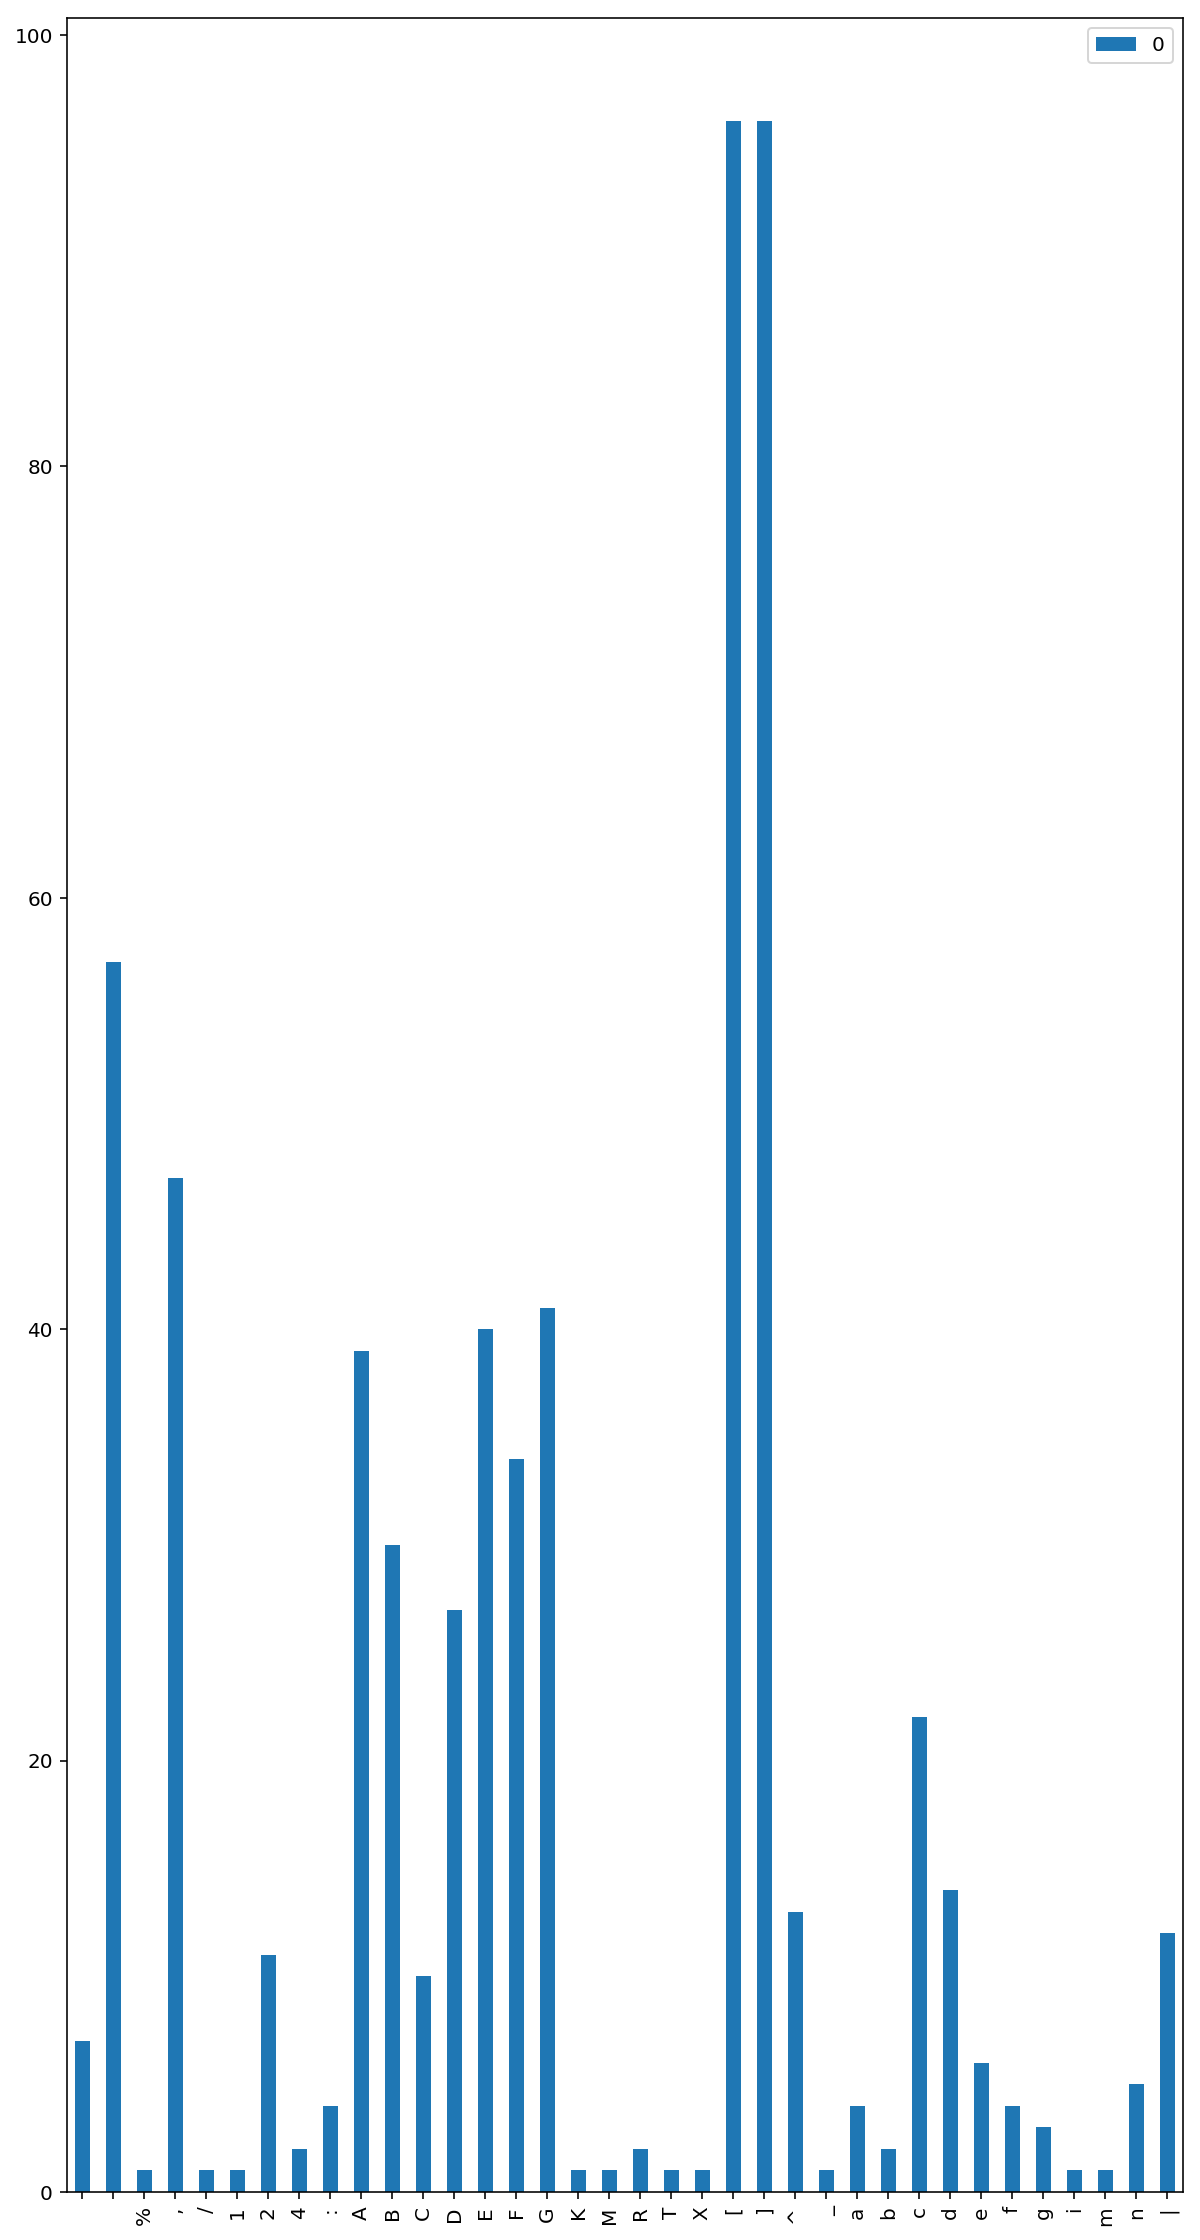

In [16]:
import pandas as pd
from collections import Counter
a = sorted(list(music_abc))
letter_counts = Counter(a)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', figsize=(10,20))

In [13]:
def idx_to_char(idx):
    return vocab_map['idx2char'][str(int(idx))]

vfunc = np.vectorize(idx_to_char)
text_map= vfunc(heatmap[0,:,0:100])

In [29]:
heatmap[1,:,0:1000][:4,:4]

array([[ 0.02958182,  0.8131507 ,  0.10241242,  0.24784282],
       [ 0.2033774 ,  0.8131507 ,  0.24275403,  0.35871959],
       [ 0.18712522,  0.04095986,  0.10241242,  0.24784282],
       [ 0.09096339,  0.02403539,  0.08286086,  0.11091366]])

#### Generate heat map of model character prediction

/home/cseos2g/datduyn/.conda/envs/cs478project/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


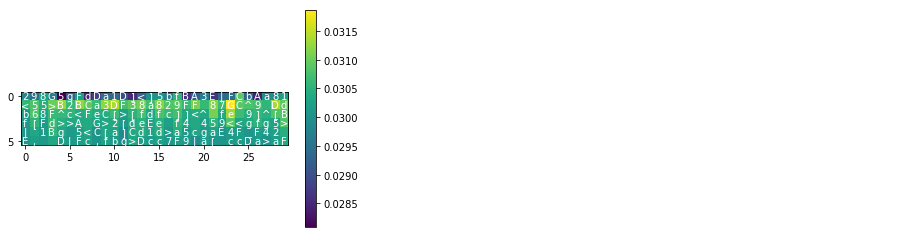

In [14]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
fig, ax = plt.subplots()
im = ax.imshow(heatmap[1,:,0:30])

# Loop over data dimensions and create text annotations.
for i in range(len(text_map)):
    for j in range(len(text_map[0])):
        text = ax.text(j, i, text_map[i, j],
                       ha="center", va="center", color="w")
# fig.colorbar(ax)
fig.colorbar(im,ax=ax)
fig.tight_layout()

In [154]:
heat_map[1]

array([[  5.98930180e-01,   6.99655414e-01,   9.98980939e-01,
          6.74393117e-01,   4.61797208e-01,   2.62753487e-01,
          7.37917781e-01,   9.84767139e-01,   2.62753487e-01,
          8.93393159e-01],
       [  9.20788348e-02,   2.06741422e-01,   2.28617093e-04,
          1.20498024e-01,   2.19840884e-01,   1.96328655e-01,
          2.03195214e-01,   4.51483112e-03,   1.96328655e-01,
          2.31623147e-02],
       [  5.88871650e-02,   3.22715864e-02,   1.66049082e-04,
          5.39283492e-02,   1.18779249e-01,   1.88566580e-01,
          2.05463115e-02,   3.28564504e-03,   1.88566580e-01,
          1.42358653e-02],
       [  5.53393178e-02,   3.03188227e-02,   9.80730038e-05,
          2.70178188e-02,   9.04975384e-02,   7.19026774e-02,
          1.64709259e-02,   2.77934317e-03,   7.19026774e-02,
          1.26095721e-02],
       [  3.86340655e-02,   1.29396087e-02,   9.12688774e-05,
          1.58256814e-02,   3.36676463e-02,   6.42791986e-02,
          1.52911050e-02

### Convert abc notation to midi

In [22]:
from music21 import *
abcScore = converter.parse(music_abc, format='abc')
mf = midi.translate.streamToMidiFile(abcScore)
mf.open('./midi_epoch20-03.mid', 'wb')
mf.write()
mf.close()

# Utility
## Quick Abc to midi converter
- http://www.mandolintab.net/abcconverter.php

## midi 2 musicsheet converter
- https://solmire.com/miditosheetmusic/

## Major and Minor
- https://www.youtube.com/watch?v=fKpUBsn_jmA
- help create mood and atmossphere of music